**Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?**

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from itertools import permutations
from scipy.stats import boxcox, jarque_bera,normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from IPython.display import Markdown, display
import scipy
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

#Display Preferences
%matplotlib inline
pd.options.display.float_format ='{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

import warnings
warnings.filterwarnings(action='ignore')

In [73]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user,postgres_pw,postgres_host,postgres_port,postgres_db))
df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()
df.head(10)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Un

In [74]:
# Function defintions which are used repeatedly 
#Function to group neighborhood 
def classify_neighbor(saleprice):
    
    nbr_class = {0:'saleprice < 120000',
                 1:'saleprice >= 120000 and saleprice < 200000',
                 2:'saleprice >= 200000 and saleprice < 300000',
                 3:'saleprice >= 300000'
                }

    for class_level in nbr_class.keys():
        if eval(nbr_class[class_level]):
            return class_level

df['neighborhood_class'] = df['saleprice'].apply(classify_neighbor)

#Function to take temp values for the model and output salesprice log transformed
def log_prep(temp_df):

    temp_df['saleprice_log'] = np.log(temp_df['saleprice'])
    temp_df.drop(columns=['saleprice'],inplace=True)

    #desginate features
    features = list(temp_df.columns)
    features.remove('saleprice_log')
    print('features (len: {}): {}\ntarget: {}'.format(len(features),{i for i in features},list(set(set(temp_df.columns)-set(features)))))

    X = temp_df[features]
    Y = temp_df['saleprice_log']
    return X,Y

def optimize_ElasticNet(x,y,title):

    #clf = ElasticNet(max_iter=2000, l1_ratio = [.1,.5,.7,.9,.95,.99,1], normalize=True)
    clf = ElasticNet(max_iter=2000, l1_ratio = 0.5, normalize=True)
    clf.fit(x,y)
    print("score", clf.score(x,y))
    print(clf.get_params)
    pred=clf.predict(x)
    plt.title("Scatter plot of prediction and " + title)
    plt.xlabel("Prediction")
    plt.ylabel("Target")
    plt.scatter(y, pred)
    
    # Show perfect fit line
    plt.plot(y, y, label="Perfect Fit")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ElasticNet(clf.alpha,clf.l1_ratio,clf.fit_intercept,clf.normalize,clf.copy_X,clf.tol,positive=True)
    #return ElasticNet(alpha=clf.alpha_,l1_ratio=clf.l1_ratio_,fit_intercept=clf.fit_intercept,normalize=clf.normalize,copy_X=clf.copy_X,tol=clf.tol,positive=True)

def plot_showErrors(y_test, y_preds, title):

    plt.scatter(y_test, y_preds)
    plt.plot(y_test,y_test)
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("House prices: true vs. predicted values")
    plt.show()
    # Measure model errors
    print("{} MODEL ERRORS\n**********************************".format(title.upper()))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))
    print(('*'*20))

features (len: 6): {'yearbuilt', 'fullbath', 'neighborhood_class', 'totalbsmtsf', 'garagecars', 'yearremodadd'}
target: ['saleprice_log']
score 0.0
<bound method BaseEstimator.get_params of ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=2000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)>


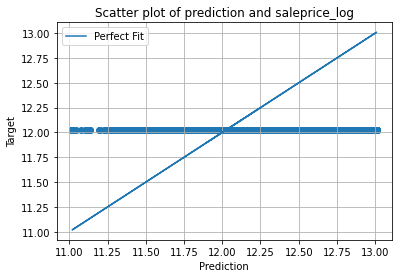

In [75]:
#MODEL prep
# count missing values

missing_vals = (df.isnull().sum()/len(df)).sort_values(ascending=False)
missing_vals = missing_vals[missing_vals > 0]

#data types
missingvalDtypes = df[missing_vals.index.to_list()].dtypes

# Create a dictionary containing the value to replace missing values in each column
fill_with = {'garageyrblt': 0, 'garagequal': 'TA', 'garagecond': 'TA', 'garagefinish': 'Unf','garagetype':'No',
             'bsmtexposure':'No','bsmtfintype2':'Unf','bsmtfintype1':'Unf','bsmtqual':'TA','bsmtcond':'TA',
             'masvnrarea':0,'masvnrtype':'None','electrical':'SBrkr'}


# Also, fill first 5 columns with 0 for missing values
fill_with.update({key:0 for key in missing_vals[:5].index.to_list()})

if 'id' in df.columns:
    df = df.drop(columns=['id'])
df = df.fillna(value=fill_with)

# Select features & split dataset
features = ['saleprice', 'neighborhood_class', 'garagecars', 'totalbsmtsf', 'fullbath',
            'yearbuilt', 'yearremodadd']
temp_df = df[features]

for i in ['saleprice', 'totalbsmtsf']:
    temp_df[i] = winsorize(temp_df[i], (0.01, 0.01))

X, Y = log_prep(temp_df)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


## Linear regression
model_1 = ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, 
                       precompute='auto', max_iter=1000, tol=0.0001, cv=10, copy_X=True, verbose=0, n_jobs=-1, 
                       positive=False, random_state=None, selection='cyclic')
hParams = model_1.__dict__

# Initiate ElasticNet model based on ElasticNetCV
optimized_OLS = optimize_ElasticNet(X, Y,'saleprice_log')

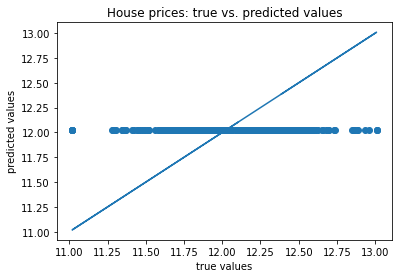

OLS MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.3119852800129102
Mean squared error of the prediction is: 0.15291420828968236
Root mean squared error of the prediction is: 0.39104246353776256
Mean absolute percentage error of the prediction is: 2.5938577938137057
********************


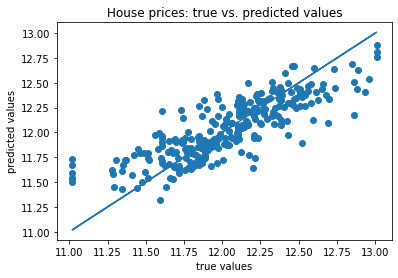

KNN MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.1681341332120157
Mean squared error of the prediction is: 0.04824841179539498
Root mean squared error of the prediction is: 0.21965521117286285
Mean absolute percentage error of the prediction is: 1.4029611479413475
********************


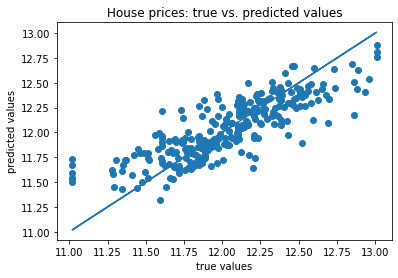

KNN_MINKOWSKI MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.1681341332120157
Mean squared error of the prediction is: 0.04824841179539498
Root mean squared error of the prediction is: 0.21965521117286285
Mean absolute percentage error of the prediction is: 1.4029611479413475
********************


In [76]:
# Fit our ElasticNet model, show its prediction and model valuation metrics
optimized_OLS.fit(X_train,y_train)
plot_showErrors(y_test,optimized_OLS.predict(X_test),'ols')


# KNN Regressor
gridOv_params = {'n_neighbors':[6,9,10,12,14,15,16,18],
                 'weights':['uniform','distance'],
                 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'leaf_size':[5,9,20,30,45,50,55,90],
                 'metric':['minkowski','manhattan','euclidean'],
                 'n_jobs':[-1]
                }
clf0 = GridSearchCV(KNeighborsRegressor(),param_grid=gridOv_params,n_jobs=-1)
clf0.fit(X_train,y_train)
gridOv_params = clf0.best_params_
clf0 = KNeighborsRegressor(algorithm=gridOv_params['algorithm'],
                           leaf_size=gridOv_params['leaf_size'],
                           metric=gridOv_params['metric'],
                           n_jobs=gridOv_params['n_jobs'],
                           n_neighbors=gridOv_params['n_neighbors'],
                           weights=gridOv_params['weights'])
clf0.fit(X_train,y_train)
plot_showErrors(y_test,clf0.predict(X_test),'knn')



clf1 = KNeighborsRegressor(algorithm=gridOv_params['algorithm'],
                           leaf_size=gridOv_params['leaf_size'],
                           metric='minkowski',
                           n_jobs=gridOv_params['n_jobs'],
                           n_neighbors=gridOv_params['n_neighbors'],
                           weights=gridOv_params['weights'])
clf1.fit(X_train,y_train)

plot_showErrors(y_test,clf0.predict(X_test),'knn_minkowski')
